# Walkthrough for Jupyter

In this notebook we'll walk through how to get rolling with Notebooks.

Important to note that **Jupyter Notebook file ≠ a Python file.**

## 1. Generating the data

For this demo, lets generate two distinct clusters of (x,y,z) coordinate data.

In [1]:
# BAD CODE, DON"T DO THIS:
import numpy as np
total_numbers = 200
mean1, std_dev1 = 0, 4
cluster1 = np.random.normal(mean1, std_dev1, size=(total_numbers,3))
mean2, std_dev2 = 10, 5
cluster2 = np.random.normal(mean2, std_dev2, size=(total_numbers,3))

In [149]:
# Preamble:
import numpy.random as rnd
import pickle as pkl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import plotly as py
import plotly.graph_objs as go
import tensorflow as tf
from sklearn import model_selection
from IPython.display import clear_output

py.offline.init_notebook_mode(connected=True)
%matplotlib inline

# Global Vars:
total_numbers = 200
number_of_clusters = 2
mean, std_dev = [0, 10], [4, 5]

# Set a seed:
rnd.seed(42) 

In [49]:
def generate_data():
    "This function generates <number_of_clusters> set of x,y,z points"
    global data_points
    
    data_points = [None] * number_of_clusters
    
    for i in range(number_of_clusters):
        data_points[i] = rnd.normal(mean[i], std_dev[i], size=(total_numbers,3))

# generate_data()

Now that we have data generated in `data_points`, we don't want to re-generate it everytime. It takes time to compute, and when randomness is at play, we might get different numbers every time. Getting different numbers everytime means we won't know if things have changed for the better. 

**Use seeds!** They are critical in being able to have reproductivity in your code. All variables which deal with randomness and machine learning have a seed option that can be set.

When data has been generated in python, it doesn't need to be re-generated everytime. The `pickle` package is your best friend!

In [81]:
def save_pickle_file(name, data):
    "Save out the data as a pickle file"
    with open("output/{}.pkl".format(name), "wb") as pickle_file:
        pkl.dump(data, pickle_file)

def load_pickle_file(name):
    "Get the value from the pickle file and set it as the variable value"
    with open("output/{}.pkl".format(name), "rb") as pickle_file:        
        globals()[name] = np.array(pkl.load(pickle_file))
    
#save_pickle_file("data_points", data_points)
load_pickle_file("data_points")

## 2. Visualize what we have

Visualizations are one of the key features of Jupyter Notebooks. 

I personally like jot down the type of visualization I am aiming for on paper.

![drawn graph](images/drawing.jpg "Drawing")

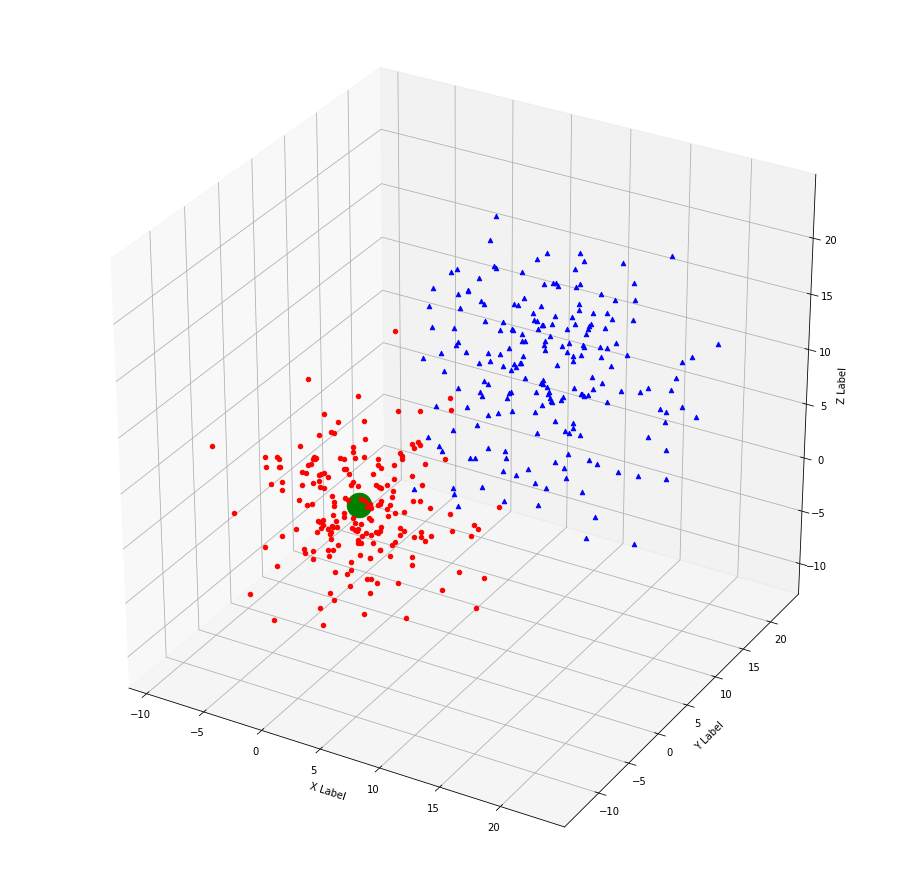

In [157]:
# %load snippets/3dplot.py
marks_and_colors = ["r", "o"], ["b", "^"]

def plot_3d(new_point=False):
    "Makes a 3d plot for a given dataset"
    fig = plt.figure(figsize=(16, 16)) # easy way to get bigger figures
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter points:
    i = 0
    for group in data_points:
        for point in group:
            ax.scatter(point[0], point[1], point[2], c=marks_and_colors[i][0], marker=marks_and_colors[i][1])
        i = i + 1

    # Check to see if new_point is set:
    if new_point:
        ax.scatter(new_point[0], new_point[1], new_point[2], c="g", marker="o", s=600)
        
    # Labels:
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()
    
    # Save the image:
    fig.savefig('output/3d-plot.png')
    plt.close(fig)  

plot_3d(new_point=[0, 0, 0])

Cool! We got the visualization that we wanted, and we save it out everytime it is rendered. Saving the image out and putting it on version control (`git`) is a great way to track the graphics.

### Interactive Visualizations 

Interactive visualizations are not much harder than the interactive one. For our particular case, we will be using [Plot.ly](https://plot.ly/). The service requires you to create an account and have an API key (follow [these instructions](https://plot.ly/python/getting-started/)). 

Even though Plot.ly is a paid service, I have a little life-hack which allows you to create as many plots as you want while sticking to the free plan.

In [131]:
# %load snippets/3d-interactive-plot.py
def interactive_3d_plot(new_point=False, save=False):
    data = []
    
    # Marker and color info 
    marks_and_interactive = ["red", "circle"], ["blue", "diamond"]
    
    # Scatter points:
    i = 0
    for g in data_points:
        group = go.Scatter3d(
            x=g[:,0],
            y=g[:,1],
            z=g[:,2],
            mode='markers',
            name='Grouping {}'.format(i+1),
            marker=dict(
                color=marks_and_interactive[i][0],
                size=12,
                symbol=marks_and_interactive[i][1],
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.2
                ),
                opacity=0.6
            )
        )
        data.append(group)
        i = i + 1
        
    # If a new_point is set:
    if new_point:
        point = go.Scatter3d(
            x=[new_point[0]],
            y=[new_point[1]],
            z=[new_point[2]],
            mode='markers',
            name='Test point',
            marker=dict(
                color='green',
                size=12,
                symbol='circle',
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.2
                ),
                opacity=1
            )
        )
        data.append(point)
    
    # The layout for the plot:
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    
    # To save the plot, pass in a flag and then render the plot out as a .html file:
    if save:
        file_name = "3d-interactive-plot"
        py.offline.plot({"data": data, "layout": layout}, 
                            auto_open=False, filename="output/{}.html".format(file_name))
        print("Saved the file {}".format(file_name))
    
    # Use the offline plot to see the plot:
    py.offline.iplot({"data":data, "layout":layout})

In [112]:
interactive_3d_plot()

## 3. Machine Learning

Let's create a basic `tensorflow` model which is able to classify any given point as either group 1 (red group) and group 2 (blue group).

In [51]:
# %load snippets/ml.py
def deep_classifier():
    '''
    Make a basic tensorflow DNN
    '''
    # Get the data into an np array which makes things easy
    data = np.concatenate((data_points[0], data_points[1]), axis=0)
    labels = np.repeat([0, 1], 200)
    
    # Split into training and testing data:
    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        data, labels, test_size=0.2, random_state=72)
    
    feature_columns = [tf.feature_column.numeric_column('x', shape=np.array(x_train).shape[1:])] 
    
    get_train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x':x_train}, y=y_train, num_epochs=100, shuffle=True)
    
    get_test_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x':x_test}, y=y_test, num_epochs=1, shuffle=True)
    
    # Create a DNN classifier:
    classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns, 
            hidden_units=[1000, 100, 10], n_classes=2, model_dir="model",
            optimizer=tf.train.ProximalAdagradOptimizer(
                learning_rate=0.0001,
                l1_regularization_strength=0.01),
                config=tf.estimator.RunConfig().replace(save_summary_steps=10))
    
    # Train the classifier:
    classifier.train(input_fn=get_train_input_fn, steps=1000)

    scores = classifier.evaluate(input_fn=get_test_input_fn)
    
    print('Accuracy (tf.estimator): {0:f}'.format(scores['accuracy']))
    
    return classifier

In [52]:
classifier = deep_classifier()

INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2adbf5095748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-2113
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2114 into model/model.ckpt.
INFO:tensorflow:loss =

Different results can be gotten by changing various parameters of the DNNClassifier (such as the `learning_rate` and `num_epochs`). Since the same directory `model/` is being used to serve TensorBoard, TensorBoard will keep track of historical models.

In [64]:
# The points:
points = np.array([[3, -3, 0], [15, 7, 17]]) # Answers: class 0, then class 1
    
def try_our_own_point():
    "Try to predict the class of the point for our own point"
    our_point_fn = tf.estimator.inputs.numpy_input_fn(x={'x':points}, shuffle=False)

    # Make a prediction:
    prediction = classifier.predict(input_fn=our_point_fn)
    return prediction

for index, pred in enumerate(list(try_our_own_point())):
    print(points[index], '→' , pred['class_ids'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-2363
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[ 3 -3  0] → [0]
[15  7 17] → [1]


## 4. Interactivity

Most people do not know this but Jupyter has a built in feature which allows us to to easily take in user input. Here we'll take in the `x,y,z` points from the user and then make a classification based on the model prediction.

In [213]:
from ipywidgets import widgets
%matplotlib inline

In [214]:
# Define the x, y, z sliders
x = widgets.FloatSlider(
    value=1.0,
    min=np.min(data_points[0][:, 0]),
    max=np.max(data_points[1][:, 0]),
    step=1.0,
    description='X:',
    continuous_update = False
)

y = widgets.FloatSlider(
    value=1.0,
    min=np.min(data_points[0][:, 1]),
    max=np.max(data_points[1][:, 1]),
    step=1.0,
    description='Y:',
    continuous_update = False
)

z = widgets.FloatSlider(
    value=1.0,
    min=np.min(data_points[0][:, 2]),
    max=np.max(data_points[1][:, 2]),
    step=1.0,
    description='Z:',
    continuous_update = False
)

button = widgets.Button(description="Predict Point")

In [215]:
box = widgets.HBox(children=[x, y, z, button])

In [216]:
def slide_change(change):
    #interactive_3d_plot(new_point = point)
    
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter points:
    i = 0
    for group in data_points:
        for point in group:
            ax.scatter(point[0], point[1], point[2], c=marks_and_colors[i][0], marker=marks_and_colors[i][1])
        i = i + 1
        
    ax.scatter(x.value, y.value, z.value, c="g", marker="o", s=600)
        
    # Labels:
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

#x.observe(slide_change, names="value")

# Listen for when the button is clicked, then make the callback:
button.on_click(slide_change)

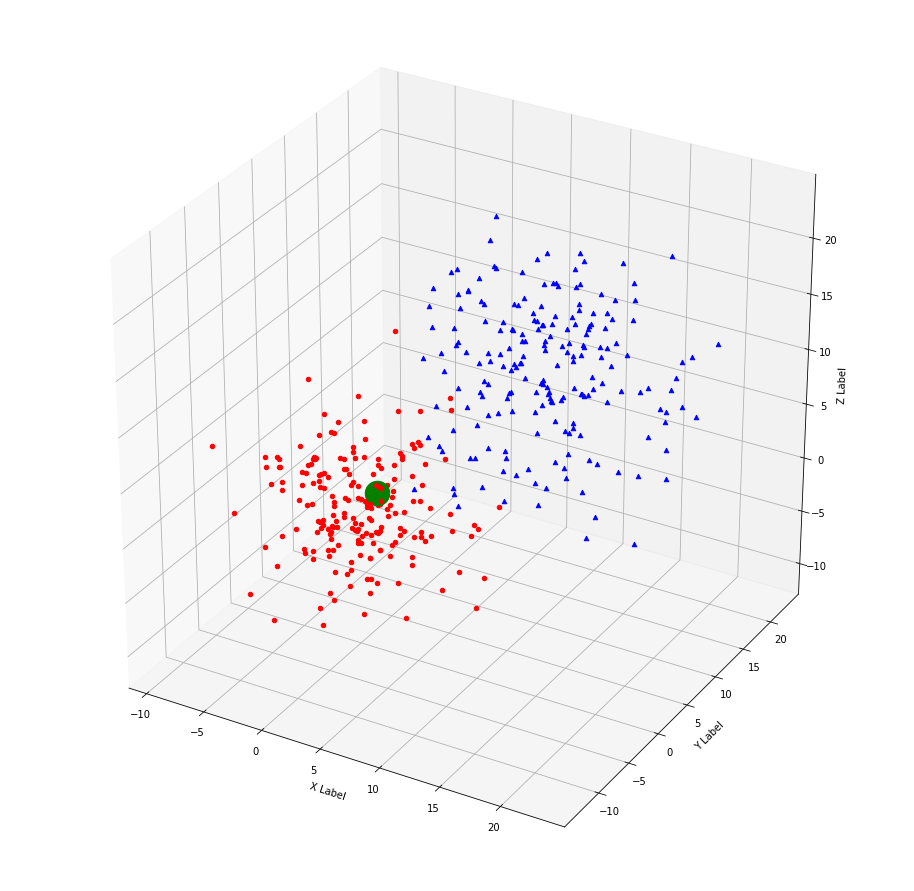

In [217]:
display(box)